# Calculate Ocean Bottom Pressure Anomaly fields relative to their 2005-1020 mean

Ian Fenty, 2025-04-23

* Assumes OBP files are on a local disk
* Assumes use of Dask and at least 16 processors
* Assumes ecco_v4_py package is installed
* 
> NOTE: ECCO V4 OBP mds files are '>f8' (double precision'


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob

import matplotlib.pyplot as plt
import os
import time;
from pprint import pprint
from pathlib import Path

## Initalize Python libraries
from datetime import datetime
import requests
import shutil
import time as time
from os.path import basename, isfile, isdir, join, expanduser
import sys

#sys.path.append('/home/jpluser/git_repos/ECCOv4-py')
import ecco_v4_py as ecco
from xmitgcm import open_mdsdataset


In [2]:
import dask as dask

In [3]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster

#from distributed import Client
client = Client('127.0.0.1:8786')
client.restart()


In [4]:
def make_filename(new_prefix, timestep):
    filename = new_prefix + '.' + str(np.char.zfill(str(timestep),10)) + '.data'
    return filename

In [5]:
mds_grid_dir = '/home/jpluser/efs-mount-point/ifenty/granules/mds_grid_dir/'

model_start_datetime = np.datetime64('1992-01-01T12:00:00'),
delta_t=3600
grid_vars_to_coords=True
default_dtype = np.dtype('>f4')
read_grid=False


## Daily Mean OBP --> OBPAnoma_day_mean

In [6]:
old_mds_var_dir = '/tmp/OBP_day_mean'

new_mds_var_dir = Path('/tmp/OBPAnoma_day_mean')
new_mds_var_dir.mkdir(exist_ok=True)

new_mds_var_ref_dir = Path('/tmp/OBPAnoma_day_mean_reference')
new_mds_var_ref_dir.mkdir(exist_ok=True)

old_prefix='OBP_day_mean'
new_prefix = 'OBPAnoma_day_mean'

vtl='OBP'
ofc='AVG_DAY'


## Monthly Mean OBP --> OBPAnoma_mon_mean

In [71]:
old_mds_var_dir = '/tmp/OBP_mon_mean'

new_mds_var_dir = Path('/tmp/OBPAnoma_mon_mean')
new_mds_var_dir.mkdir(exist_ok=True)

new_mds_var_ref_dir = Path('/tmp/OBPAnoma_mon_mean_reference')
new_mds_var_ref_dir.mkdir(exist_ok=True)

old_prefix='OBP_mon_mean'
new_prefix = 'OBPAnoma_mon_mean'

vtl='OBP'
ofc='AVG_MON'


In [7]:
mds_files = np.sort(list(Path(old_mds_var_dir).glob('*data')))
mds_files = [str(mds_file).split('/')[-1] for mds_file in mds_files]
mds_files

['OBP_day_mean.0000000012.data',
 'OBP_day_mean.0000000036.data',
 'OBP_day_mean.0000000060.data',
 'OBP_day_mean.0000000084.data',
 'OBP_day_mean.0000000108.data',
 'OBP_day_mean.0000000132.data',
 'OBP_day_mean.0000000156.data',
 'OBP_day_mean.0000000180.data',
 'OBP_day_mean.0000000204.data',
 'OBP_day_mean.0000000228.data',
 'OBP_day_mean.0000000252.data',
 'OBP_day_mean.0000000276.data',
 'OBP_day_mean.0000000300.data',
 'OBP_day_mean.0000000324.data',
 'OBP_day_mean.0000000348.data',
 'OBP_day_mean.0000000372.data',
 'OBP_day_mean.0000000396.data',
 'OBP_day_mean.0000000420.data',
 'OBP_day_mean.0000000444.data',
 'OBP_day_mean.0000000468.data',
 'OBP_day_mean.0000000492.data',
 'OBP_day_mean.0000000516.data',
 'OBP_day_mean.0000000540.data',
 'OBP_day_mean.0000000564.data',
 'OBP_day_mean.0000000588.data',
 'OBP_day_mean.0000000612.data',
 'OBP_day_mean.0000000636.data',
 'OBP_day_mean.0000000660.data',
 'OBP_day_mean.0000000684.data',
 'OBP_day_mean.0000000708.data',
 'OBP_day_

In [8]:
all_time_steps = ecco.get_time_steps_from_mds_files(old_mds_var_dir, old_prefix, less_output=True)
all_time_steps[0]
print(len(all_time_steps))

get time steps
10227


In [24]:
#model_time_steps_to_load=[732, 1428]
model_time_steps_to_load=all_time_steps #[:500] #[0:2000]
#model_time_steps_to_load='all'

In [71]:
# split the list of all time steps in nsplits groups
nsplits=16
all_time_steps_split = np.array_split(all_time_steps, nsplits)

In [72]:
client.restart()

In [74]:
# use Dask delayed to lazy-load the mds files 
# this is *much* faster than using one process
# I can't really tell what's happening in the dask dashboard
# it could mostly be in building the dask graph.  

@dask.delayed
def load_ecco_vars(model_time_steps_to_load):

    tmp = ecco.load_ecco_vars_from_mds(old_mds_var_dir,
                    mds_grid_dir=mds_grid_dir,
                    mds_files=old_prefix,
                    vars_to_load = vtl,
                    model_time_steps_to_load = model_time_steps_to_load,
                    model_start_datetime = np.datetime64('1992-01-01T12:00:00'),
                    delta_t = 3600,
                    output_freq_code = ofc,
                    drop_unused_coords = False,
                    grid_vars_to_coords = False,
                    coordinate_metadata = [],
                    variable_metadata = [],
                    global_metadata = [],
                    cell_bounds = None,
                    llc_method = 'smallchunks',
                    less_output=True,
                    read_grid=read_grid)
    return tmp
    

In [77]:
# build the delayed array
st = time.time()
result =[]

# loop through each model time step group (there are nsplits of them)
for i in range(nsplits):
    # figure out which time steps this process is lazy-loading
    model_time_steps_to_load = list(all_time_steps_split[i])

    # append the dask delayed load_ecco_vars to the result list
    result.append(load_ecco_vars(model_time_steps_to_load))

end_time = time.time()

# execute / compute / lazy-load
start_time = time.time()

tmp = dask.compute(result)[0]

et = time.time()

print('total time ', et-st)
print('time per record ', (et-st)/len(all_time_steps))
# should be about 0.002 seconds per time step

ecco_dataset = xr.concat(tmp, dim='time')



total time  22.185814380645752
time per record  0.002169337477329202


In [80]:
print(np.sum(~np.isfinite(ecco_dataset.OBP[0].values)))
print(np.sum(~np.isfinite(ecco_dataset.OBP[-1].values)))

0
0


In [81]:
np.median(ecco_dataset.OBP[0].values[:])

0.14185218135204092

In [82]:
ecco_dataset.timestep.load()
ecco_dataset.timestep[:10]

<xarray.DataArray 'timestep' (time: 10)> Size: 80B
array([ 12,  36,  60,  84, 108, 132, 156, 180, 204, 228])
Coordinates:
    timestep  (time) int64 80B 12 36 60 84 108 132 156 180 204 228
  * time      (time) datetime64[ns] 80B 1992-01-01T12:00:00 ... 1992-01-10T12...
Attributes:
    long_name:  model timestep number

# Calculate the 2005-2010 mean

In [84]:
# name of 2005-2010 reference file
ref_filename = new_mds_var_ref_dir / Path(str(old_prefix) + "_reference_2005-2010.nc")
print(ref_filename)

/tmp/OBPAnoma_day_mean_reference/OBP_day_mean_reference_2005-2010.nc


In [85]:
ecco_var_all = ecco_dataset[vtl]

In [88]:
ecco_var_2005_2010_slice = ecco_var_all.sel(time=slice("2005-01-01T00:00:00",
                                                       "2010-01-01T00:00:00"))
print('start and end time of slice')
print(ecco_var_2005_2010_slice.time[0].values,ecco_var_2005_2010_slice.time[-1].values)
print('nrecs = ', len(ecco_var_2005_2010_slice.time))

start and end time of slice
2005-01-01T12:00:00.000000000 2009-12-31T12:00:00.000000000
nrecs =  1826


In [89]:
1826/16

114.125

In [91]:
ecco_var_all=ecco_var_all.chunk(chunks={"time":160, "tile":13})
ecco_var_all

<xarray.DataArray 'OBP' (time: 10227, tile: 13, j: 90, i: 90)> Size: 9GB
dask.array<rechunk-merge, shape=(10227, 13, 90, 90), dtype=float64, chunksize=(160, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    timestep  (time) int64 82kB dask.array<chunksize=(160,), meta=np.ndarray>
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 82kB 1992-01-01T12:00:00 ... 2019-12-31
Attributes:
    long_name:  Ocean Bottom Pressure
    units:      m^2/s^2

In [92]:
ecco_var_2005_2010_slice_mean = ecco_var_2005_2010_slice.mean(dim='time').compute()

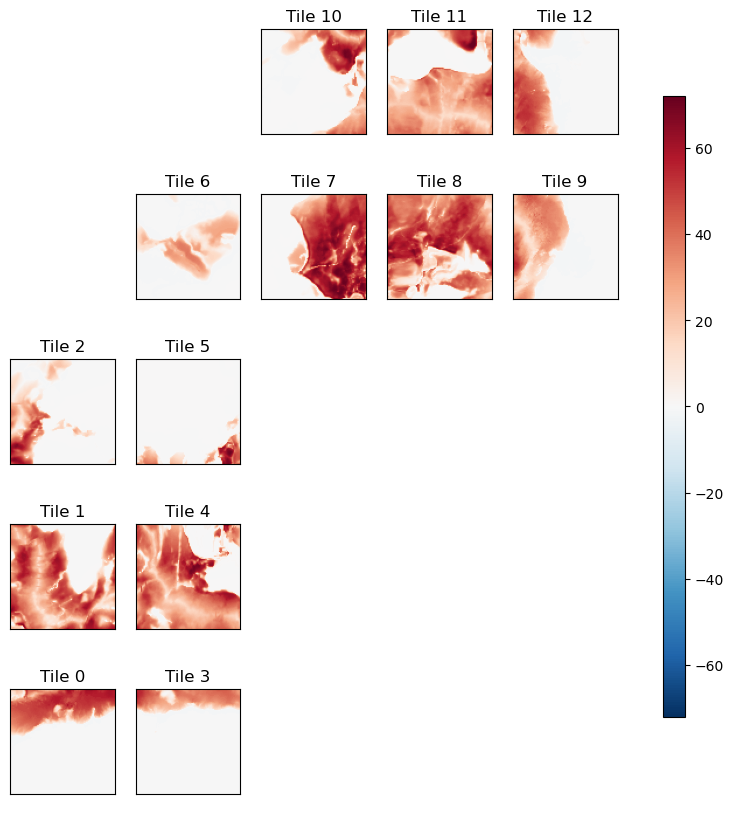

In [93]:
ecco.plot_tiles(ecco_var_2005_2010_slice_mean, show_colorbar=True);

## save reference field to disk

In [94]:
ecco_var_2005_2010_slice_mean.to_netcdf(ref_filename)

# Test production of new filename

In [95]:
timestep=732
str(np.char.zfill(str(timestep),10))
new_filename = make_filename(new_prefix, 732)
print(new_filename)

timestep=732
str(np.char.zfill(str(timestep),10))
new_filename = make_filename(old_prefix, 732)
print(new_filename)

OBPAnoma_day_mean.0000000732.data
OBP_day_mean.0000000732.data


# Remove reference mean from all fields

In [96]:
ecco_var_all=ecco_var_all.chunk(chunks={"time":30, "tile":13})
ecco_var_all

<xarray.DataArray 'OBP' (time: 10227, tile: 13, j: 90, i: 90)> Size: 9GB
dask.array<rechunk-merge, shape=(10227, 13, 90, 90), dtype=float64, chunksize=(30, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    timestep  (time) int64 82kB dask.array<chunksize=(30,), meta=np.ndarray>
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 82kB 1992-01-01T12:00:00 ... 2019-12-31
Attributes:
    long_name:  Ocean Bottom Pressure
    units:      m^2/s^2

In [97]:
@dask.delayed
def remove_anomaly(model_timestep, ref):

    # reference field and cur_OBP are 13x90x90 arrays
    #cur_OBP = ecco_var_all.sel(time=ecco_var_all.timestep==model_timestep).values
    
    old_filename = make_filename(old_prefix, model_timestep)
    print(old_filename)
      
    cur_OBP = ecco.read_llc_to_tiles(old_mds_var_dir, old_filename, filetype='>f8')
    
    OBP_anom = cur_OBP - ref

    new_filename = make_filename(new_prefix, model_timestep)
    print(new_filename)
    
    # Save to binary file
    with open(new_mds_var_dir / new_filename, 'wb') as f:
        tmp_compact_array = ecco.llc_tiles_to_compact(OBP_anom).astype('>f8').tofile(f)
    
    return new_filename

In [98]:
client.restart()

In [99]:
reference_field = ecco_var_2005_2010_slice_mean.values

In [100]:
#[reference_field_future] = client.scatter([reference_field])
[remote_ref_field] = client.scatter([reference_field], broadcast=True)
remote_ref_field

<Future: finished, type: numpy.ndarray, key: ndarray-6ab9ed0b9d4be028eecc24ba45ce452a>

In [101]:
# build the delayed array
start_time = time.time()
result =[]
for model_timestep in all_time_steps:
    result.append(remove_anomaly(model_timestep, remote_ref_field))

end_time = time.time()
#print(end_time - start_time)
#print((end_time - start_time) / len(all_time_steps))

# execute / compute
start_time = time.time()

x = dask.compute(result)

end_time = time.time()
print(end_time - start_time)
print((end_time - start_time) / len(all_time_steps))


26.17788290977478
0.002559683476070674


# test load first and last example

load_binary_array: loading file /tmp/OBPAnoma_day_mean/OBPAnoma_day_mean.0000000012.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f8
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f8
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f8


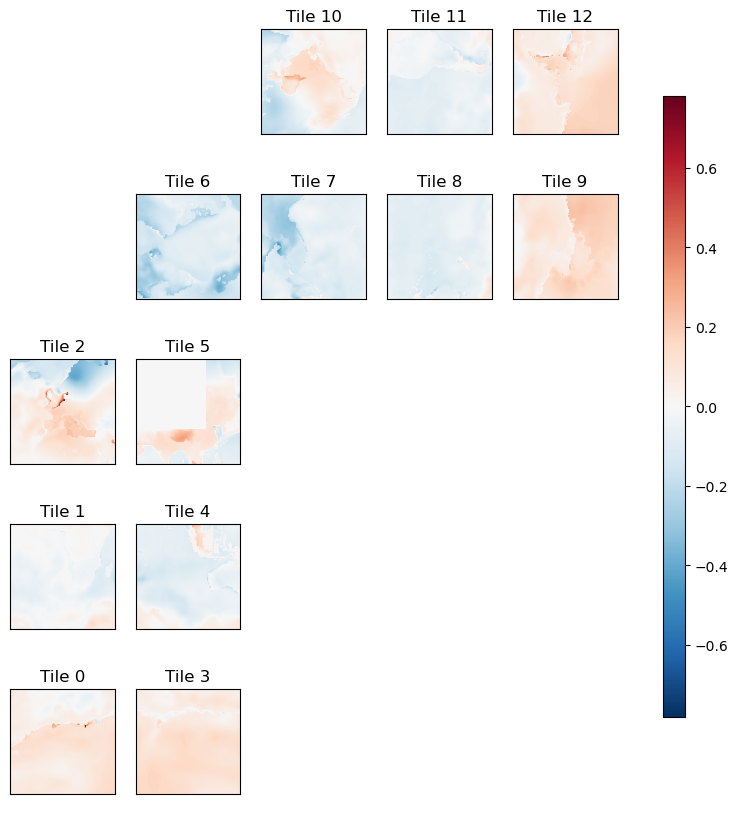

In [102]:
tmpA = ecco.read_llc_to_tiles(new_mds_var_dir, x[0][0], filetype='>f8')
ecco.plot_tiles(tmpA, show_colorbar=True);

load_binary_array: loading file /tmp/OBPAnoma_day_mean/OBPAnoma_day_mean.0000245424.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f8
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f8
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f8


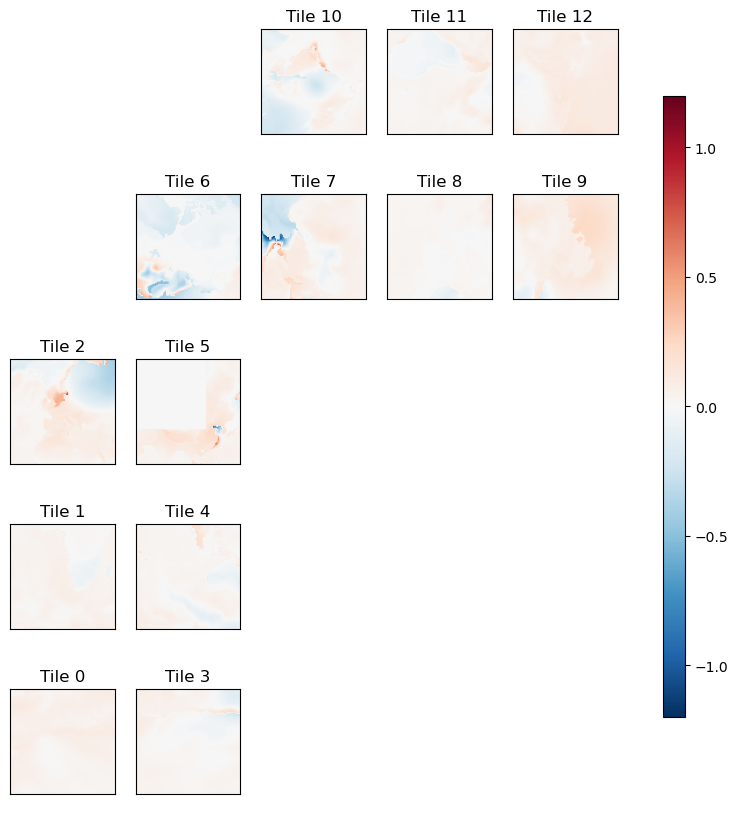

In [103]:
tmpB = ecco.read_llc_to_tiles(new_mds_var_dir, x[0][-1], filetype='>f8')
ecco.plot_tiles(tmpB, show_colorbar=True);

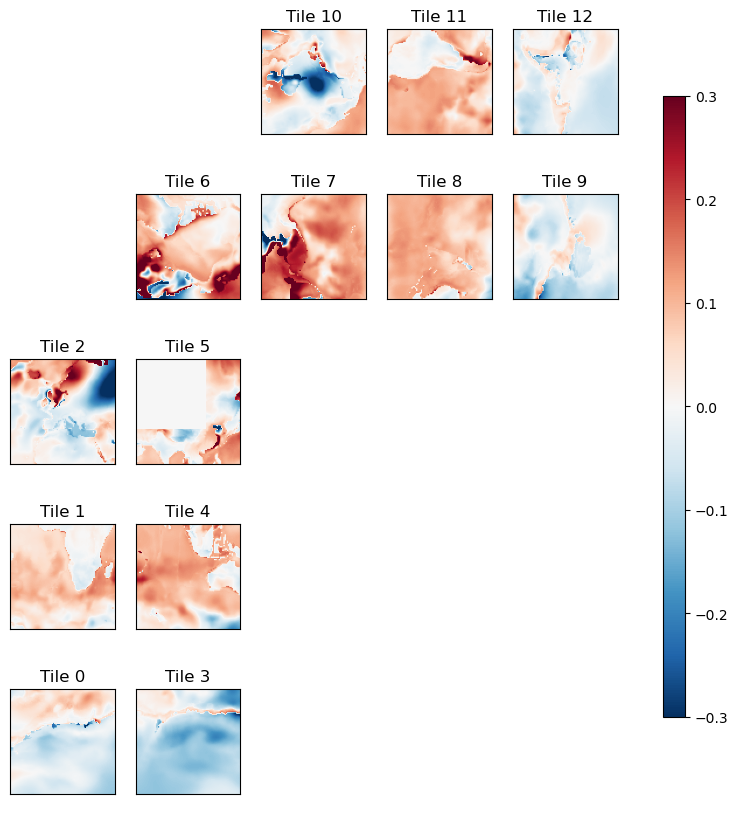

In [106]:
ecco.plot_tiles(tmpB-tmpA, show_colorbar=True, cmin=-.3, cmax=.3);